In [1]:
%load_ext autoreload
%autoreload 2
from data import *
from models import *
from train import *
from torchsummary import summary
from rich.progress import Progress
torch.manual_seed(0)
device="cuda"
path = "/lustre/home/lmucko/.fastai/data/coco_sample/train_sample" 

In [2]:
trainloader, testloader = get_loaders(batch_size=16, num_workers=16)

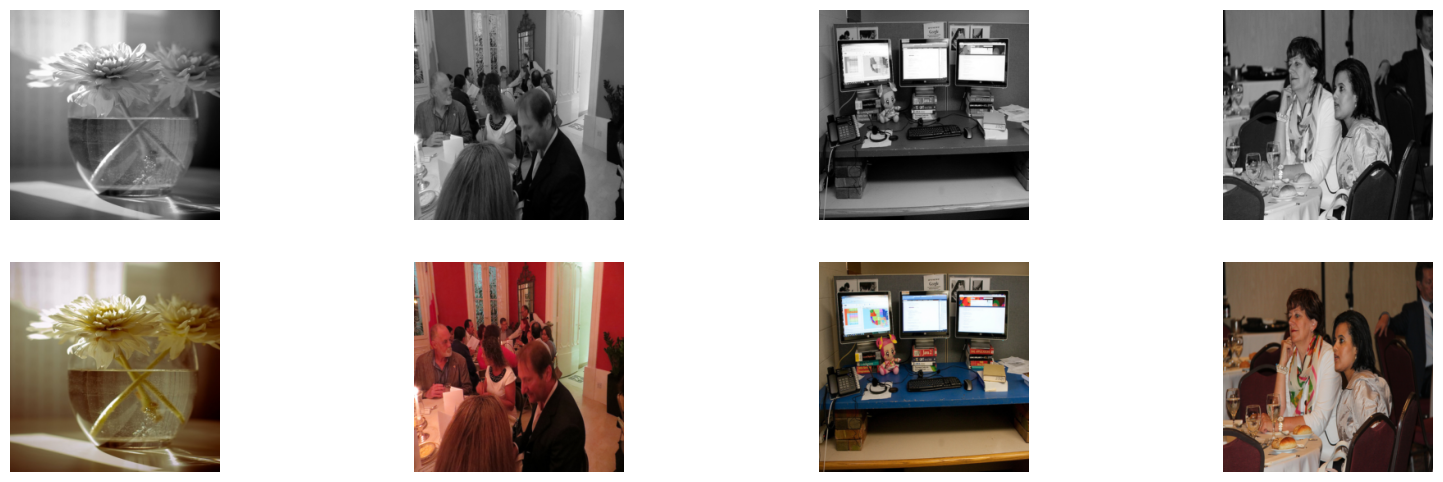

In [3]:
show_batch(testloader)

In [4]:
generator = UNet(1,2).to(device)
#summary(generator, (1,256,256))

In [5]:
discriminator = Discriminator(3).to(device)
#summary(discriminator, [(1,256,256), (2,256,256)])

In [6]:
litmodel = LitModel(generator, discriminator)

Weights of UNet initialized using normal distribution with std: 0.02
Weights of Discriminator initialized using normal distribution with std: 0.02


In [19]:
def train(litmodel, epochs, trainloader, testloader, visualize_every=1, visualize=True, checkpoint_every=10):
    to_plot = next(iter(testloader))

    with Progress() as progress:
        outer_progress = progress.add_task("[bright_red]Epochs", total=epochs+150)
        inner_progress = progress.add_task("[purple4]Training", total=len(trainloader))
        
        for epoch in range(151, 150+epochs+1):
            progress.update(outer_progress, advance=1, description=f"[bright_red]Epochs {epoch}/{epochs+150}")
            i=0
            running_gen_loss = 0
            running_disc_loss = 0
            for batch in trainloader:
                gen_loss, disc_loss = litmodel.training_step(batch)
                running_gen_loss+=gen_loss
                running_disc_loss+=disc_loss
                progress.update(inner_progress, advance=1, description=f"[purple4]Training [Gen Loss: {running_gen_loss / (i + 1):.4f}] [Disc Loss: {running_disc_loss / (i + 1):.4f}]")
                i+=1        

            progress.reset(inner_progress, total=len(trainloader))
            if visualize and (epoch % visualize_every == 0 or epoch==1):
                print(f"Epoch {epoch}/{epochs}")
                litmodel.visualize(to_plot)
                
            if epoch % checkpoint_every == 0:
                litmodel.save_model(f"models/seed/generator_{epoch}.pth")
            elif epoch == epochs:
                litmodel.save_model(f"models/seed/generator_{epoch}.pth", f"models/seed/discriminator_{epoch}.pth")

Output()

Epoch 160/150

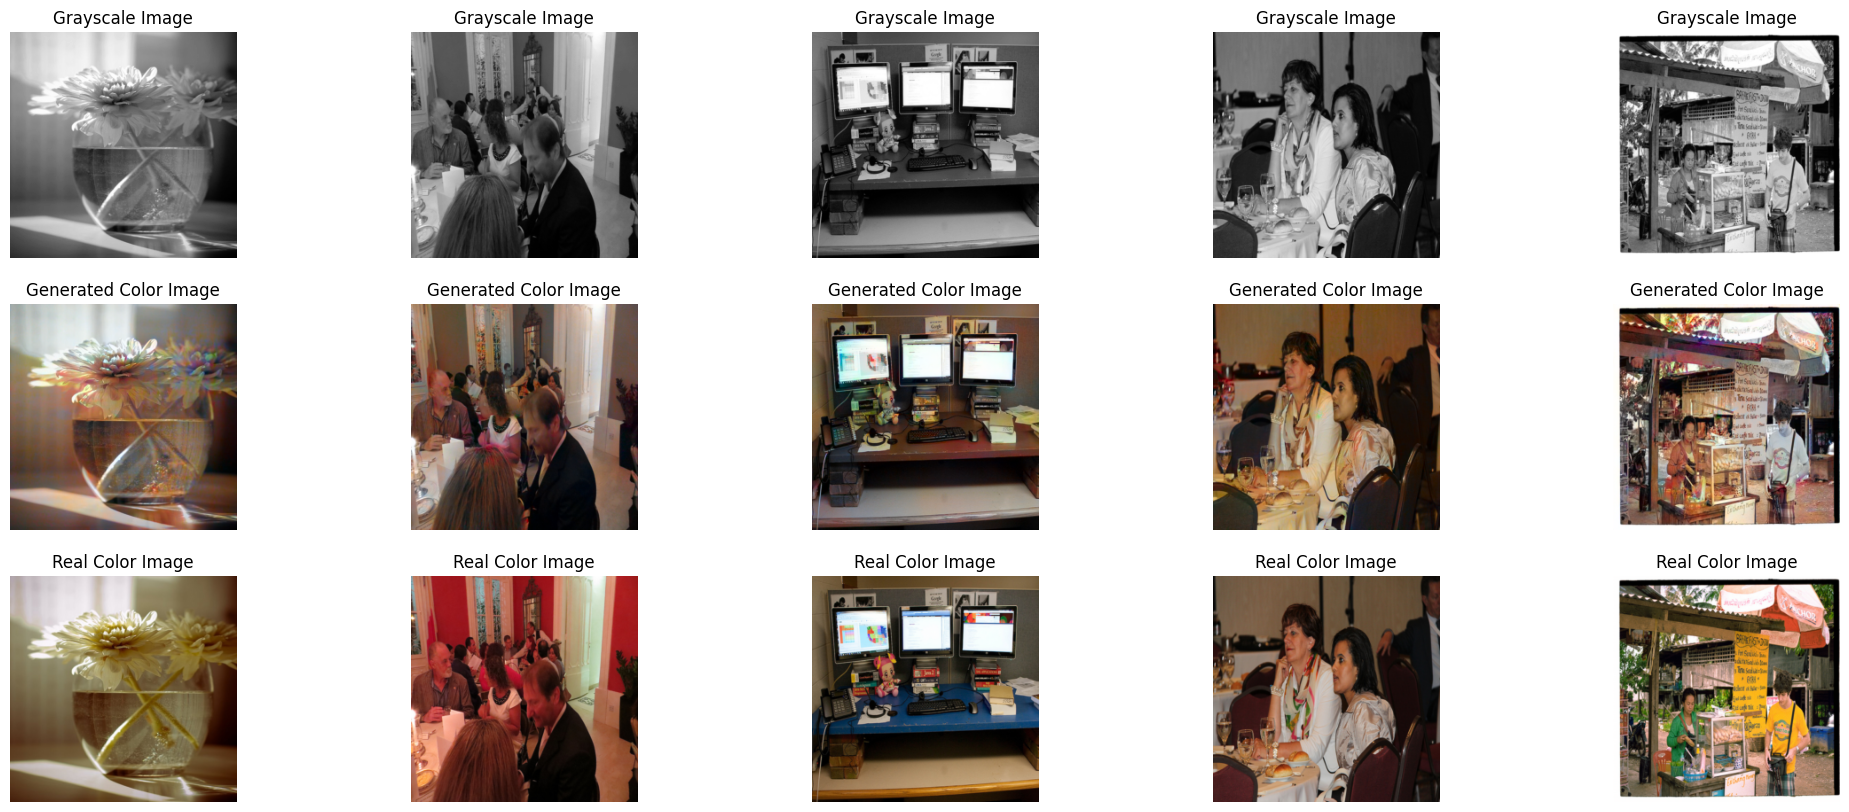

Epoch 170/150

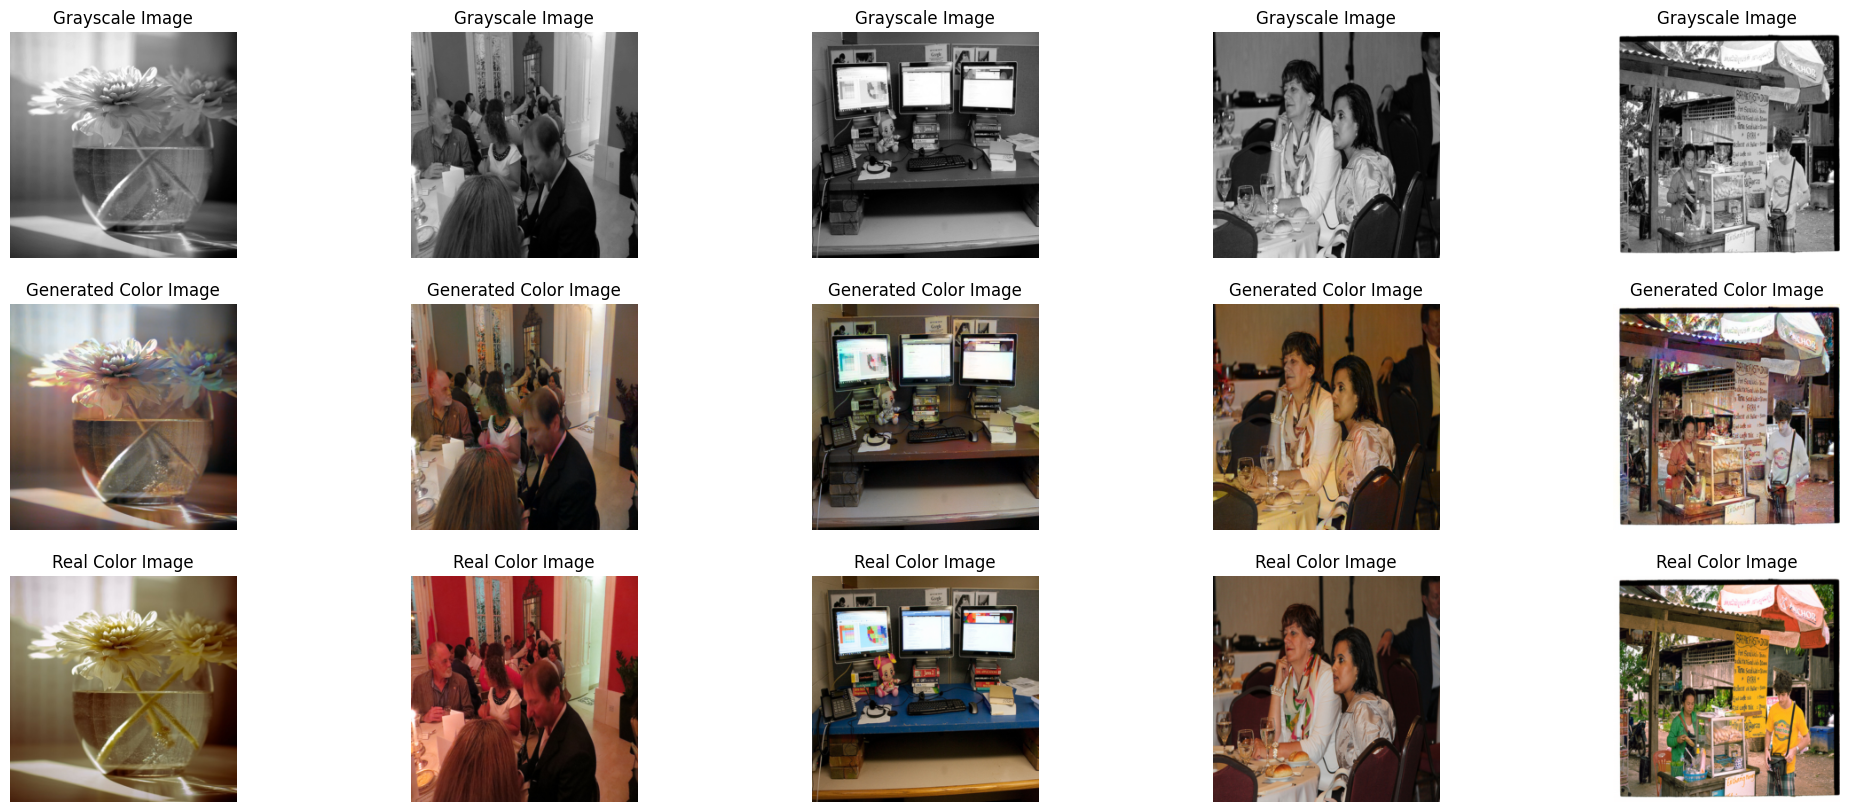

Epoch 180/150

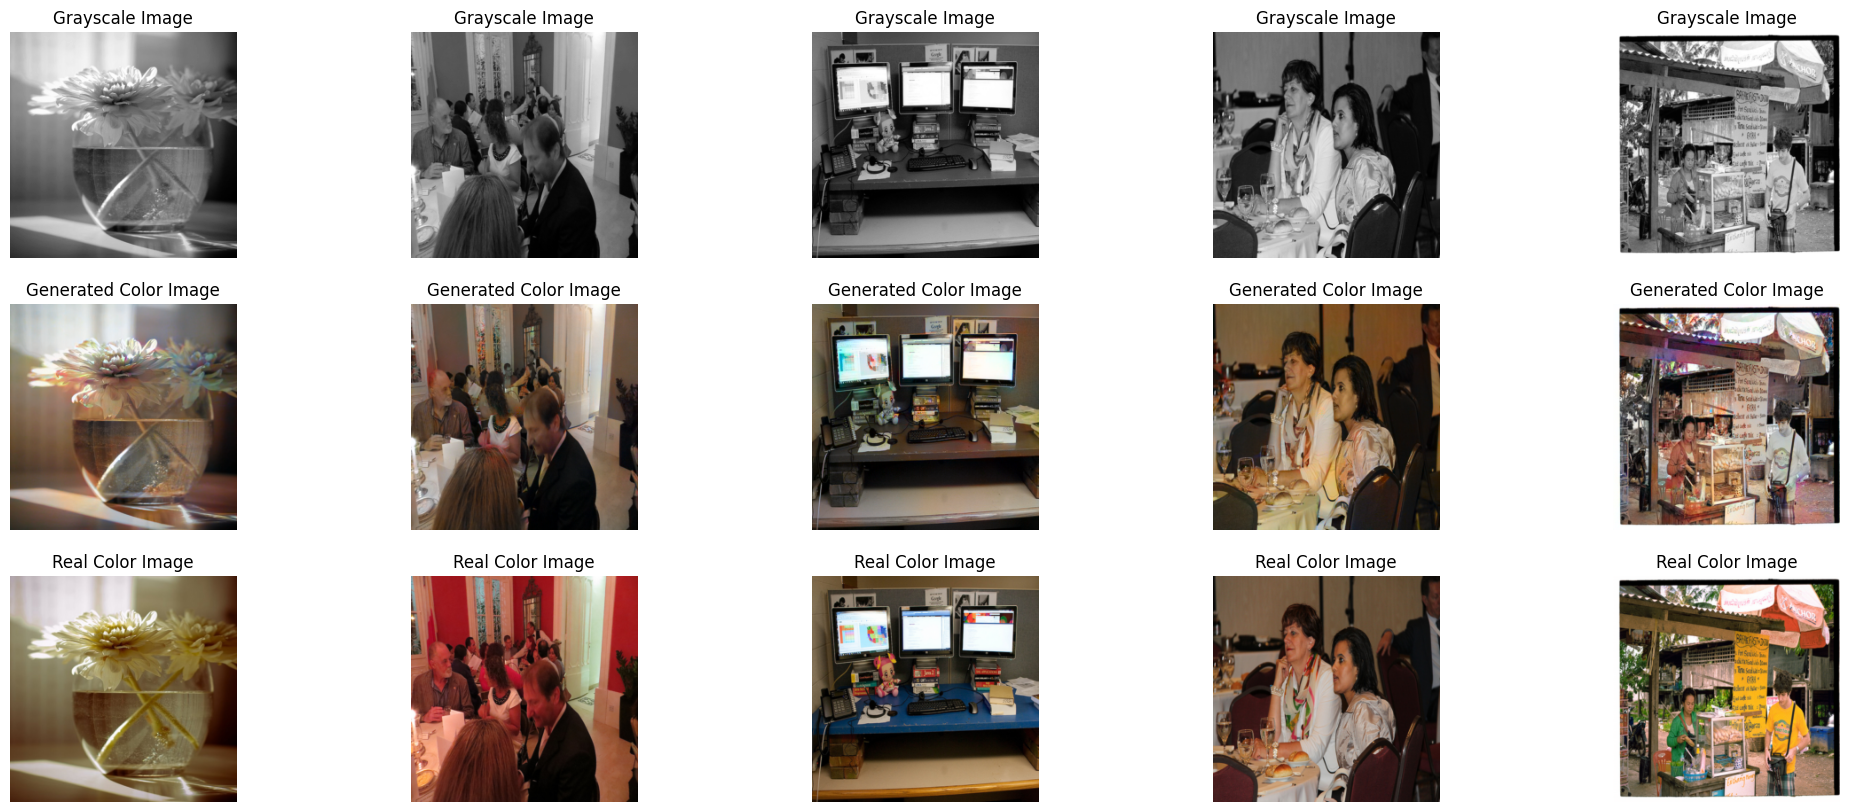

In [ ]:
train(litmodel, 150, trainloader, testloader, visualize_every=10)